<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/PlotEnergies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
%%capture
import sys

!{sys.executable} -m pip install jscatter
!{sys.executable} -m pip install ipympl
!mamba install -c conda-forge openbabel -y
#!pip install --upgrade MDAnalysis
#!mamba install -c conda-forge ambertools -y

# Import libraries

In [4]:
%matplotlib ipympl

import jscatter as js
import matplotlib.pyplot as plt
import os 
import numpy as np
from google.colab import output
import pandas as pd
import seaborn as sb 
import matplotlib.gridspec as gridspec
import pytraj as pt

js.usempl(True)  # use matplotlib
#js.usempl(False) # default, use grace on your computer with xmgrace in external window.


output.enable_custom_widget_manager()

Using  mpl


# Import Files

In [ ]:
#@title Import files from google
#from google.colab import drive

#drive.flush_and_unmount()
#drive.mount('/content/drive', force_remount=False)

In [95]:
#@title Github

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI


rm: cannot remove '/content/MD-SCPI': No such file or directory
Cloning into 'MD-SCPI'...
remote: Enumerating objects: 697, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 697 (delta 98), reused 113 (delta 53), pack-reused 497
Receiving objects: 100% (697/697), 176.84 MiB | 9.13 MiB/s, done.
Resolving deltas: 100% (328/328), done.
Updating files: 100% (169/169), done.


In [102]:
work_directory_COL = '/content/MD-SCPI/PDBs/MD/COL'
work_directory_AS4 = '/content/MD-SCPI/PDBs/MD/AS4'

files = os.listdir(work_directory_AS4)
ligand_files = np.array([file for file in files if 'ligand' in file])
[print(i, ligand_files[i]) for i in range(ligand_files.size)];

ligand_files_interesting = ['ligand-protein.dat', 'ligand-environment.dat', 'ligand-ARG92.dat', 'ligand-ASN45.dat', 'ligand-GLN51.dat', 'ligand-THR220.dat']
colors = ['black', 'blue', 'green', 'red', 'orange', 'purple']

dt = 0.002*1e3  # ste time in ns

0 ligand-SER85.dat
1 ligand-GLN51.dat
2 ligand-SER118.dat
3 ligand-THR220.dat
4 ligand-HH22.dat
5 ligand-environment.dat
6 ligand-ARG92.dat
7 ligand-solvent.dat
8 ligand-ASN45.dat
9 ligand-protein.dat


In [103]:
# plt.close()
# energies = pd.DataFrame()

# for file in ligand_files_interesting:
#   data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore='#'
#   energy = pd.DataFrame({'time':data.X/dt, 'energy':data.Y + data.eY, 'with':[file[7:-4]]*data.Y.size})
#   energies = energies.append(energy, ignore_index=True)

# g = sb.jointplot(data=energies, x="time", y="energy", hue="with", xlim=(-2,502), height=10, ratio=4) #marginal_kws=dict(bins=30))
# g.ax_marg_x.remove()

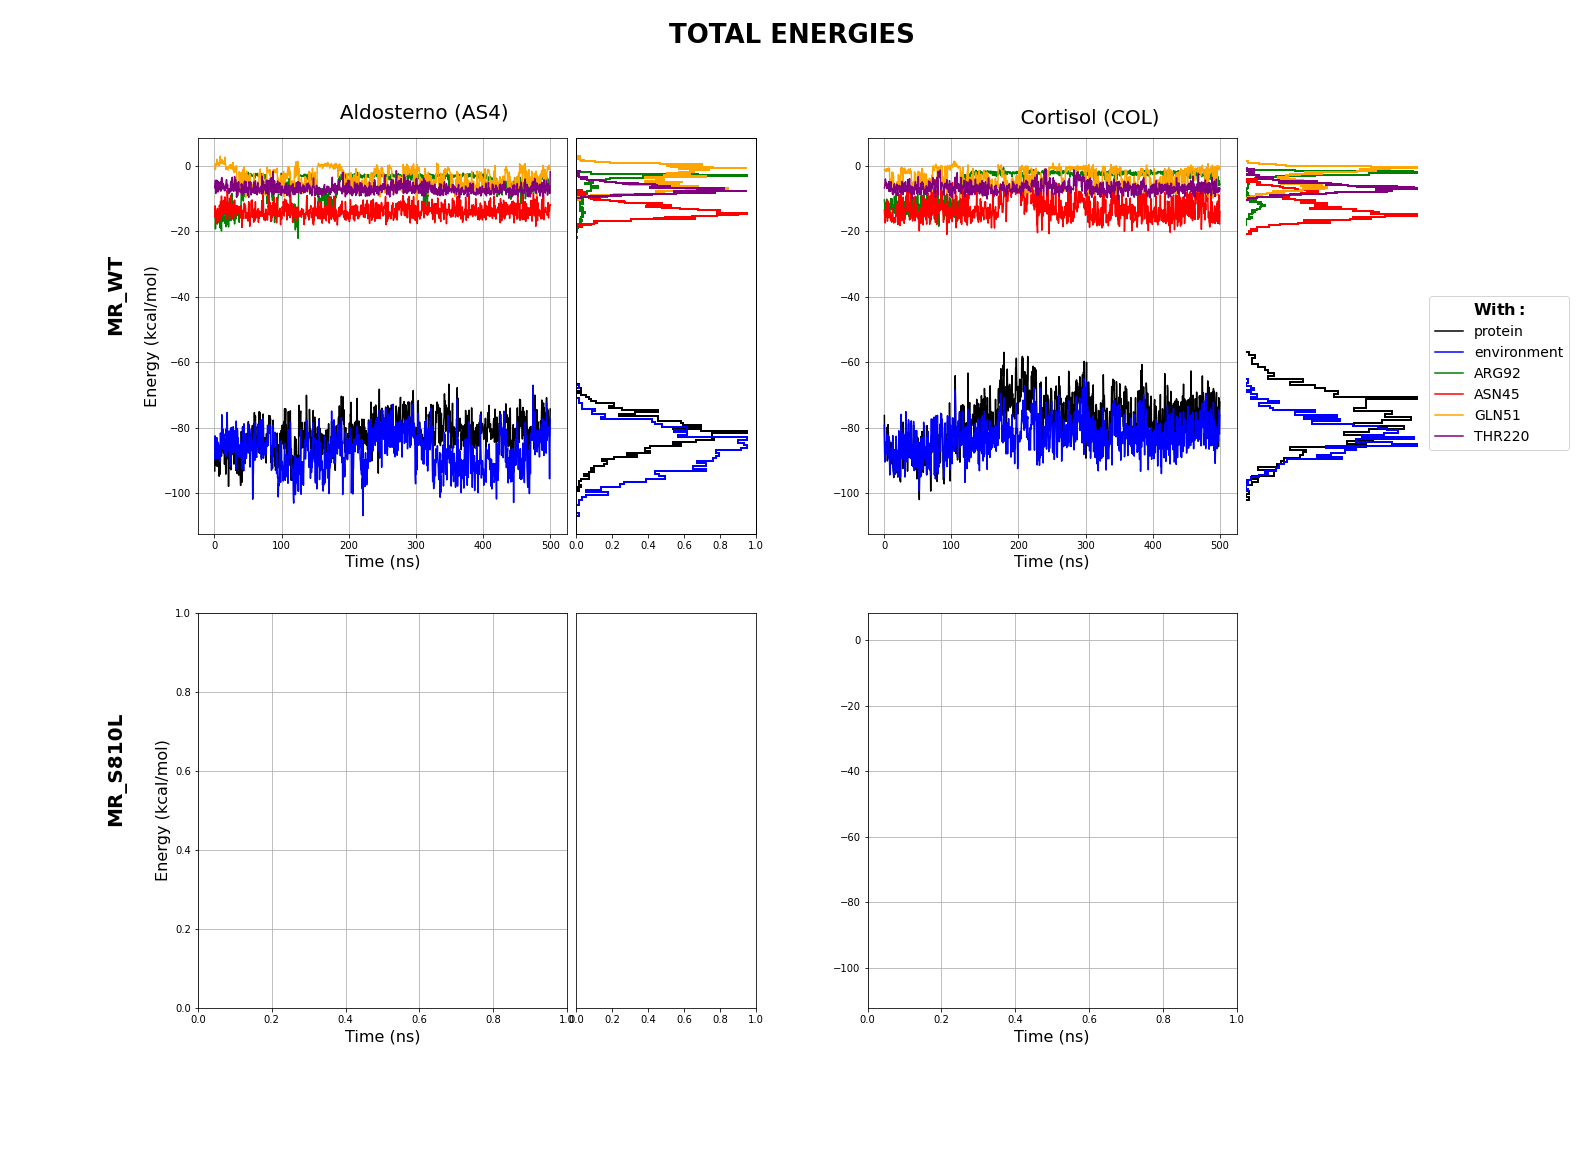

In [107]:
def RemoveBox(ax):
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)

def PlotEnergies(work_directories, figsize=(22,16), bins=100, bins_cum=50):
  plt.close()
  fig = plt.figure(figsize=figsize)
  gs0 = gridspec.GridSpec(2, 2, figure=fig)

  # -------- cortisol --------------
  gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,0], wspace=0.05)
  ax_main = plt.subplot(gs00[0:2, :2])
  ax_main.grid(True)
  ax_yDist = plt.subplot(gs00[:1, 2],sharey=ax_main)

  c=0
  for i in range(len(ligand_files_interesting)):
    data=js.dA(os.path.join(work_directories[0], ligand_files_interesting[i])) 
    x, y = data.X/dt, data.Y + data.eY
    ax_main.plot(x,y,'-', label=ligand_files_interesting[i][7:-4], color=colors[i])
    
    
    #ax_yDist.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
    ax_yCumDist = ax_yDist.twiny()
    ax_yCumDist.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=2)
    
    ax_yCumDist.tick_params(top=False, labeltop=False, left=False, labelleft=False)
    ax_yDist.tick_params(top=False, labeltop=False, left=False, labelleft=False)
    
    c+=1

  ax_main.text(-160, -50, 'MR_WT', fontsize='20', fontweight='bold', rotation=90)
  ax_main.text(-160, -200, 'MR_S810L', fontsize='20', fontweight='bold', rotation=90)

  ax_main.set_title('             Aldosterno (AS4)', fontweight='normal', fontsize='20', pad=20)
  ax_main.set_xlabel("Time (ns)", fontsize='16')
  ax_main.set_ylabel("Energy (kcal/mol)", fontsize='16')
  #ax_main.legend(bbox_to_anchor=(1.75, .5), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.)

  #ax_yDist.set(xlabel='count')
  #ax_yCumDist.tick_params('x', colors='r')
  #ax_yCumDist.set_xlabel('cumulative',color='r')

  # ------------ aldosterone --------------
  gs01 = gs0[0,1].subgridspec(1, 3, wspace=0.05)
  ax_main_1 = plt.subplot(gs01[0:2, :2])
  ax_yDist_1 = plt.subplot(gs01[:1, 2],sharey=ax_main_1)
  ax_main_1.grid(True)

  for i in range(len(ligand_files_interesting)):
    data=js.dA(os.path.join(work_directories[1], ligand_files_interesting[i])) 
    x, y = data.X/dt, data.Y + data.eY
    ax_main_1.plot(x,y,'-', label=ligand_files_interesting[i][7:-4], color=colors[i])

    #ax_yDist_1.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
    ax_yCumDist_1 = ax_yDist_1.twiny()
    ax_yCumDist_1.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=2)
    
    ax_yCumDist_1.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yDist_1.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)

    RemoveBox(ax_yDist_1); RemoveBox(ax_yCumDist_1);

  ax_main_1.set_title('            Cortisol (COL)', fontweight='normal', fontsize='20', pad=15)
  ax_main_1.set_xlabel("Time (ns)", fontsize='16')
  ax_main_1.sharey(ax_main); ax_main_1.sharex(ax_main)
  #ax_yDist_1.axis('off');    ax_yCumDist_1.axis('off')
  
  #ax_main.set_ylabel("Total Energy (kcal/mol)", fontsize='16')

  ax_main_1.legend(bbox_to_anchor=(1.9, .6), title='$\\bf{With:}$', fontsize='14', title_fontsize='16', borderaxespad=0.)

  ##############################################
  # --------------- MUTATIONS -----------------
  # -------- cortisol --------------
  gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1,0], wspace=0.05)
  ax_main_2 = plt.subplot(gs00[0:2, :2])
  ax_main_2.grid(True)

  ax_yDist_2 = plt.subplot(gs00[:1, 2],sharey=ax_main_2)

  for i in range(len(ligand_files_interesting)):
  #   data=js.dA(os.path.join(work_directories[2], ligand_files_interesting[i])) 
  #   x, y = data.X/dt, data.Y + data.eY
  #   ax_main_2.plot(x,y,'-', label=ligand_files_interesting[i][7:-4], color=colors[c])

  #   ax_yDist_2.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
  #  ax_yCumDist_2 = ax_yDist_2.twiny()
  #   ax_yCumDist_2.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=2)
    
  #  ax_yCumDist_2.tick_params(top=False, labeltop=False, left=False, labelleft=False)
    ax_yDist_2.tick_params(top=False, labeltop=False, left=False, labelleft=False)
    

  #ax_main_2.set_title('             Aldosterno (AS4)', fontweight='normal', fontsize='20')
  ax_main_2.set_xlabel("Time (ns)", fontsize='16')
  ax_main_2.set_ylabel("Energy (kcal/mol)", fontsize='16')
  #ax_main.legend(bbox_to_anchor=(1.75, .5), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.)

  #ax_yDist.set(xlabel='count')
  #ax_yCumDist.tick_params('x', colors='r')
  #ax_yCumDist.set_xlabel('cumulative',color='r')

  # ------------ aldosterone --------------
  gs01 = gs0[1,1].subgridspec(1, 3, wspace=0.05)
  ax_main_3 = plt.subplot(gs01[0:2, :2])
  ax_yDist_3 = plt.subplot(gs01[:1, 2],sharey=ax_main_1)
  ax_main_3.grid(True)

  for i in range(len(ligand_files_interesting)):
  #   data=js.dA(os.path.join(work_directories[3], ligand_files_interesting[i])) 
  #   x, y = data.X/dt, data.Y + data.eY
  #   ax_main_3.plot(x,y, '-', label=ligand_files_interesting[i][7:-4], color=colors[i])

  #   #ax_yDist_3.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
  #   ax_yCumDist_3 = ax_yDist_1.twiny()
  #   ax_yCumDist_3.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=2)
    
   # ax_yCumDist_3.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yDist_3.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)

    RemoveBox(ax_yDist_3); #RemoveBox(ax_yCumDist_3);

  #ax_main_3.set_title('            Cortisol (COL)', fontweight='normal', fontsize='20')
  ax_main_3.set_xlabel("Time (ns)", fontsize='16')
  ax_main_3.sharey(ax_main)



  
  plt.suptitle('TOTAL ENERGIES', fontweight='bold', fontsize='26') #for MR Ligand Systems
  plt.show()   #fig.tight_layout()
  return fig

PlotEnergies([work_directory_COL, work_directory_AS4], bins=100, bins_cum=50);

In [ ]:
def PlotsEnergies(work_directory_AS4, work_directory_COL):

  plt.close()
  fig, axs = plt.subplots(1,2,figsize=(20,8))

  # -------------- aldosterone -------------------------
  c = 0
  for file in ligand_files_interesting:
    data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore='#'
    axs[0].plot(data.X/dt, data.Y + data.eY, label=file[7:-4], color=colors[c])
    c+=1

  axs[0].set_xlabel('Time (ns)', fontsize='14')
  axs[0].set_ylabel('Kcal/mol', fontsize='14')
  axs[0].set_title('Aldosterno (AS4)', fontweight='normal', fontsize='20')
  axs[0].set_ylim((-110, 10)); #axs[0].set_xlim((-0.02, 502))

  # ------------------ cortisol --------------------------
  c=0
  for file in ligand_files_interesting:
    data=js.dA(os.path.join(work_directory_COL, file)) # , ignore='#'
    axs[1].plot(data.X/dt, data.Y + data.eY, label=file[7:-4], color=colors[c])
    c+=1

  axs[1].set_xlabel('Time (ns)', fontsize='14')
  axs[1].set_ylabel('Kcal/mol', fontsize='14')
  legend = axs[1].legend(bbox_to_anchor=(1.2, .75), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.) 
  axs[1].set_title('Cortisol (COL)', fontweight='normal', fontsize='20')
  #axs[1].set_ylim((-110, 10)); axs[1].set_xlim((-5, 1005))

  axs[1].sharey(axs[0]); axs[1].sharex(axs[0]) # share x and y axis

  #plt.rcParams['legend.title_fontweight'] = 'bold'

  # axs[1].legend(loc="lower left", ncol=len(ligand_files_interesting), bbox_to_anchor=(0, .0))#bbox_to_anchor=(1.25, .75), title='Residue', fontsize='14', title_fontsize='16')#, borderaxespad=0.) # 
  plt.suptitle('Total Energies for MR Ligand', fontweight='bold', fontsize='24')
  fig.tight_layout()
  plt.show()

  return fig

In [ ]:
#sb.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species")

In [ ]:

# plt.close()
# fig, axs = plt.subplots(2,2,figsize=(18,14))

# # -------------- aldosterone -------------------------
# for file in ligand_files_interesting:
#   data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore='#'
#   axs[0,0].plot(data.X/dt, data.Y + data.eY, label=file[7:-4])

# #axs[0,0].set_xlabel('Time (ns)', fontsize='14')
# axs[0,0].set_ylabel('Kcal/mol', fontsize='14')
# axs[0,0].set_title('Aldosterno (AS4)', fontweight='normal', fontsize='20')
# axs[0,0].set_ylim((-110, 10)); #axs[0].set_xlim((-0.02, 502))

# # ------------------ cortisol --------------------------
# for file in ligand_files_interesting:
#   data=js.dA(os.path.join(work_directory_COL, file)) # , ignore='#'
#   axs[0,1].plot(data.X/dt, data.Y + data.eY, label=file[7:-4])

# #axs[0,1].set_xlabel('Time (ns)', fontsize='14')
# #axs[0,1].set_ylabel('Kcal/mol', fontsize='14')
# legend = axs[0,1].legend(bbox_to_anchor=(1.2, .75), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.) 
# axs[0,1].set_title('Cortisol (COL)', fontweight='normal', fontsize='20')
# #axs[1].set_ylim((-110, 10)); axs[1].set_xlim((-5, 1005))

# axs[0,1].sharey(axs[0,0]); axs[0,1].sharex(axs[0,0]) # share x and y axis
# axs[1,0].sharey(axs[0,0]); axs[1,0].sharex(axs[0,0])
# axs[1,1].sharey(axs[0,0]); axs[1,1].sharex(axs[0,0])

# #plt.rcParams['legend.title_fontweight'] = 'bold'


# axs[1,0].set_xlabel('Time (ns)', fontsize='14')
# axs[1,1].set_xlabel('Time (ns)', fontsize='14')
# axs[1,0].set_ylabel('Kcal/mol', fontsize='14')

# # axs[1].legend(loc="lower left", ncol=len(ligand_files_interesting), bbox_to_anchor=(0, .0))#bbox_to_anchor=(1.25, .75), title='Residue', fontsize='14', title_fontsize='16')#, borderaxespad=0.) # 
# plt.suptitle('Total Energies for MR Ligand', fontweight='bold', fontsize='24')
# fig.tight_layout()
# plt.show()

In [ ]:
interaction = 'ligand-ASN45.dat'

def PlotAllEnergies(interaction):
  data=js.dA(os.path.join(work_directory_AS4, interaction), ignore='#')

  fig = plt.figure(figsize=(11,6))
  plt.plot(data.X, data.Y, label='Elec')
  plt.plot(data.X, data.eY, label="VDW")
  plt.plot(data.X, data.Y + data.eY, label='Total')
  plt.xlabel('Frame'); plt.ylabel('K Cal')
  plt.legend(bbox_to_anchor=(1.05, .5), title='Energy0')
  plt.title('Energies of ligand-ASN45.dat', fontweight='bold', fontsize='18')
  
  plt.show()

  return fig

In [ ]:
#help(data)

In [ ]:
#p=js.mplot()
#p.plot(data)